<a href="https://colab.research.google.com/github/mtryptnkr-study/Supply-Chain-Optimization/blob/main/SC_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import pandas as pd
from pulp import *

## Importing Datasets

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [96]:
var_costs = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/variable_costs.xlsx', index_col = 0)

var_costs


,USA,Germany,Japan,Brazil,India
Variable Costs ($/Unit),,,,,
USA,12,12,12,12,12
Germany,13,13,13,13,13
Japan,10,10,10,10,10
Brazil,8,8,8,8,8
India,5,5,5,5,5


In [97]:
freight_costs = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/freight_costs.xlsx', index_col = 0)

freight_costs

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,0,12250,1100,16100,8778
Germany,13335,0,8617,20244,10073
Japan,15400,22750,0,43610,14350
Brazil,16450,22050,28000,0,29750
India,13650,15400,24500,29400,0


In [98]:
storage_costs = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/Storage_costs.xlsx', index_col = 0)

storage_costs

,Low,High
Storage Costs ($/unit),,
USA,43.333333,63.333333
Germany,33.200000,48.466667
Japan,41.533333,60.666667
Brazil,21.533333,31.533333
India,14.066667,41.066667


In [99]:
carbon_emissions = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/CO2_Emissions.xlsx', index_col = 0)

carbon_emissions

,USA,Germany,Japan,Brazil,India
CO2 Emissions (kgs),,,,,
USA,0.000000,84.062095,299.317166,125.522063,181.069151
Germany,84.062095,0.000000,267.654340,140.791485,149.307907
Japan,299.317166,267.654340,0.000000,282.624979,127.726291
Brazil,125.522063,140.791485,282.624979,0.000000,191.409089
India,181.069151,149.307907,127.726291,191.409089,0.000000


In [100]:
lead_time = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/Delivery_LeadTime.xlsx', index_col = 0)

lead_time

,USA,Germany,Japan,Brazil,India
USA,3,21,65,29,41
Germany,21,3,59,33,34
Japan,65,59,3,62,30
Brazil,29,33,62,3,43
India,41,34,30,43,3


In [101]:
total_costs = freight_costs/1000 + var_costs
total_costs

,USA,Germany,Japan,Brazil,India
Freight Costs ($/Container),,,,,
USA,12.000,24.25,13.100,28.100,20.778
Germany,26.335,13.00,21.617,33.244,23.073
Japan,25.400,32.75,10.000,53.610,24.350
Brazil,24.450,30.05,36.000,8.000,37.750
India,18.650,20.40,29.500,34.400,5.000


In [102]:
fixed_costs = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/fixed_cost.xlsx', index_col = 0)

fixed_costs

,Low,High
USA,6500,9500
Germany,4980,7270
Japan,6230,9100
Brazil,3230,4730
India,2110,6160


In [103]:
total_fixed_costs = fixed_costs + storage_costs

total_fixed_costs

,Low,High
USA,6543.333333,9563.333333
Germany,5013.200000,7318.466667
Japan,6271.533333,9160.666667
Brazil,3251.533333,4761.533333
India,2124.066667,6201.066667


In [104]:
delivery_times = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/Delivery_LeadTime.xlsx', index_col = 0)

delivery_times

,USA,Germany,Japan,Brazil,India
USA,3,21,65,29,41
Germany,21,3,59,33,34
Japan,65,59,3,62,30
Brazil,29,33,62,3,43
India,41,34,30,43,3


In [105]:
capacity = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/capacity.xlsx', index_col = 0)

capacity

,Low,High
Capacity (kUnits/month),,
USA,500,1000
Germany,500,1000
Japan,500,1000
Brazil,500,1000
India,500,1000


In [106]:
demand = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/demand.xlsx', index_col = 0)

demand

,Demand
(Units/month),
USA,2800000
Germany,90000
Japan,1700000
Brazil,145000
India,160000


In [107]:
Co2_dict = {
    'USA': 10000000000,
    'Germany': 10000000000,
    'Japan': 10000000000,
    'Brazil': 10000000000,
    'India': 1000000000
}
Co2_dict

Co2_limits = pd.DataFrame(Co2_dict.items(), columns = ['Country', 'Max CO2 permitted (in kgs)'])
Co2_limits.set_index('Country')

,Max CO2 permitted (in kgs)
Country,
USA,10000000000
Germany,10000000000
Japan,10000000000
Brazil,10000000000
India,1000000000


In [108]:
del_deadline = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Supply Chain Optimization/Datasets/Delivery_Deadlines.xlsx', index_col = 0)

del_deadline

,USA,Germany,Japan,Brazil,India
USA,30,30,30,30,30
Germany,30,30,30,30,30
Japan,30,30,30,30,30
Brazil,30,30,30,30,30
India,30,30,30,30,30


## Building the linear programming model from Pulp Library

In [109]:
# Define Decision Variables through a list
loc = ['USA', 'Germany', 'Japan', 'Brazil', 'India']
size = ['Low', 'High']

In [110]:
# Initialize Class
model = LpProblem("Capacitated Plant Location Model", LpMinimize)

/usr/local/lib/python3.12/dist-packages/pulp/pulp.py:1489: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [111]:
# Create Decision Variables
x = LpVariable.dicts("production_", [(i,j) for i in loc for j in loc],
                     lowBound=0, upBound=None, cat='continuous')
y = LpVariable.dicts("plant_",
                     [(i,s) for s in size for i in loc], cat='Binary')
z = LpVariable.dicts("delivery_",[(i,j) for i in loc for j in loc], cat = 'Binary')

In [112]:
# Define Objective Function
model += (lpSum([total_fixed_costs.loc[i,s] * y[(i,s)] * 1000 for s in size for i in loc])
          + lpSum([total_costs.loc[i,j] * x[(i,j)]   for i in loc for j in loc]))


In [113]:
# Add Constraints
for j in loc:
    model += lpSum([x[(i, j)] for i in loc]) == demand.loc[j,'Demand']
for i in loc:
    model += lpSum([x[(i, j)] for j in loc]) <= lpSum([capacity.loc[i,s]*y[(i,s)] * 1000 for s in size])
for j in loc:
    model += lpSum([carbon_emissions.loc[i,j] * x[(i,j)] for i in loc]) <= [5000000000,5000000000,5000000000,5000000000,5000000000]

model += lpSum([delivery_times.loc[i,j] * z[(i,j)] for i in loc for j in loc]) <= (del_deadline.loc[i,j] for i in loc for j in loc)

In [114]:
# Define logical constraint: Add a logical constraint so that if the high capacity plant in USA is open, then a low capacity plant in Germany is also opened.
# model += y[('USA','High_Cap')] <= y[('Germany','Low_Cap')]

# Solve Model
model.solve()
print("Total Costs = {:,} ($/Month)".format(int(value(model.objective))))
print('\n' + "Status: {}".format(LpStatus[model.status]))

Total Costs = 109,556,533 ($/Month)

Status: Optimal


In [115]:
# Dictionary to display the output data after optimization:
dict_plant = {}
dict_prod = {}
for v in model.variables():
    if 'plant' in v.name:
        name = v.name.replace('plant__', '').replace('_', '')
        dict_plant[name] = int(v.varValue)
        p_name = name
    else:
        name = v.name.replace('production__', '').replace('_', '')
        dict_prod[name] = v.varValue
    print(name, "=", v.varValue)

delivery('Brazil','Brazil') = 0.0
delivery('Brazil','Germany') = 0.0
delivery('Brazil','India') = 0.0
delivery('Brazil','Japan') = 0.0
delivery('Brazil','USA') = 0.0
delivery('Germany','Brazil') = 0.0
delivery('Germany','Germany') = 0.0
delivery('Germany','India') = 0.0
delivery('Germany','Japan') = 0.0
delivery('Germany','USA') = 0.0
delivery('India','Brazil') = 0.0
delivery('India','Germany') = 0.0
delivery('India','India') = 0.0
delivery('India','Japan') = 0.0
delivery('India','USA') = 0.0
delivery('Japan','Brazil') = 0.0
delivery('Japan','Germany') = 0.0
delivery('Japan','India') = 0.0
delivery('Japan','Japan') = 0.0
delivery('Japan','USA') = 0.0
delivery('USA','Brazil') = 0.0
delivery('USA','Germany') = 0.0
delivery('USA','India') = 0.0
delivery('USA','Japan') = 0.0
delivery('USA','USA') = 0.0
('Brazil','High') = 0.0
('Brazil','Low') = 1.0
('Germany','High') = 0.0
('Germany','Low') = 0.0
('India','High') = 1.0
('India','Low') = 1.0
('Japan','High') = 1.0
('Japan','Low') = 1.0
('US

## Converting the results of models to Dataframes

In [116]:
list_low, list_high = [], []
for l in loc:
    for cap in ['Low', 'High']:
        x = "('{}','{}')".format(l, cap)
        if cap == 'Low':
            list_low.append(dict_plant[x])
        else:
            list_high.append(dict_plant[x])
df_capacity = pd.DataFrame({'Location': loc, 'Low': list_low, 'High': list_high}).set_index('Location')

df_capacity

,Low,High
Location,,
USA,1,1
Germany,0,0
Japan,1,1
Brazil,1,0
India,1,1


In [117]:
USA_List, Germany_List, Japan_List, Brazil_List, India_List = [], [], [], [], []
for l in loc:
    for var_costs in ['USA', 'Germany', 'Japan', 'Brazil', 'India']:
        x = "('{}','{}')".format(l, var_costs)
        if var_costs == 'USA':
            USA_List.append(dict_prod[x])
        elif var_costs == 'Germany':
            Germany_List.append(dict_prod[x])
        elif var_costs == 'Japan':
            Japan_List.append(dict_prod[x])
        elif var_costs == 'Brazil':
            Brazil_List.append(dict_prod[x])
        elif var_costs == 'India':
            India_List.append(dict_prod[x])

df_production = pd.DataFrame({'Location': loc, 'USA': USA_List, 'Germany': Germany_List, 'Japan': Japan_List, 'Brazil': Brazil_List, 'India': India_List}).set_index('Location')

df_production

,USA,Germany,Japan,Brazil,India
Location,,,,,
USA,1300000.0,0.0,200000.0,0.0,0.0
Germany,0.0,0.0,0.0,0.0,0.0
Japan,0.0,0.0,1500000.0,0.0,0.0
Brazil,250000.0,0.0,0.0,145000.0,0.0
India,1250000.0,90000.0,0.0,0.0,160000.0


In [118]:
df_production["Sum"] = df_production.sum(axis=1)
df_production

,USA,Germany,Japan,Brazil,India,Sum
Location,,,,,,
USA,1300000.0,0.0,200000.0,0.0,0.0,1500000.0
Germany,0.0,0.0,0.0,0.0,0.0,0.0
Japan,0.0,0.0,1500000.0,0.0,0.0,1500000.0
Brazil,250000.0,0.0,0.0,145000.0,0.0,395000.0
India,1250000.0,90000.0,0.0,0.0,160000.0,1500000.0


In [119]:
sum_list = df_production['Sum']
sum_list

,Sum
Location,
USA,1500000.0
Germany,0.0
Japan,1500000.0
Brazil,395000.0
India,1500000.0


In [120]:
low_prod, high_prod = [], []
for i,j,k in zip(list_low, list_high, sum_list):
    if i ==0 and j==1:
        high_prod.append(k)
        low_prod.append(0)
    elif i==1 and j==0:
        low_prod.append(k)
        high_prod.append(0)
    elif i==1 and j==1:
        low_prod.append(500000)
        high_prod.append(k-500000)
    else:
        low_prod.append(0)
        high_prod.append(0)
df_plot = pd.DataFrame({'Location': loc, 'Low': low_prod, 'High': high_prod})
df_plot


,Location,Low,High
0,USA,500000.0,1000000.0
1,Germany,0.0,0.0
2,Japan,500000.0,1000000.0
3,Brazil,395000.0,0.0
4,India,500000.0,1000000.0


## Case 1: Standard Conditions

In [121]:
dict_plot1 = {'Location':['USA','Germany','Japan','Brazil','India'], 'Low':[0,0,0,145000,0],'High':[1500000,0,1500000,0,1750000]}
df_plot1 = pd.DataFrame(dict_plot1)
df_plot1

,Location,Low,High
0,USA,0,1500000
1,Germany,0,0
2,Japan,0,1500000
3,Brazil,145000,0
4,India,0,1750000


In [122]:

dict_case1 = {'Location':['USA','Germany','Japan','Brazil','India'],
             'USA':[1300000,0,0,0,1500000],
             'Germany':[0,0,0,0,90000],
            'Japan':[200000,0,1500000,0,0],
            'Brazil':[0,0,0,145000,0],
            'India':[0,0,0,0,160000]}
df_case1 = pd.DataFrame(dict_case1)
df_case1

,Location,USA,Germany,Japan,Brazil,India
0,USA,1300000,0,200000,0,0
1,Germany,0,0,0,0,0
2,Japan,0,0,1500000,0,0
3,Brazil,0,0,0,145000,0
4,India,1500000,90000,0,0,160000


In [123]:
import seaborn as sns
import matplotlib.pyplot as plt

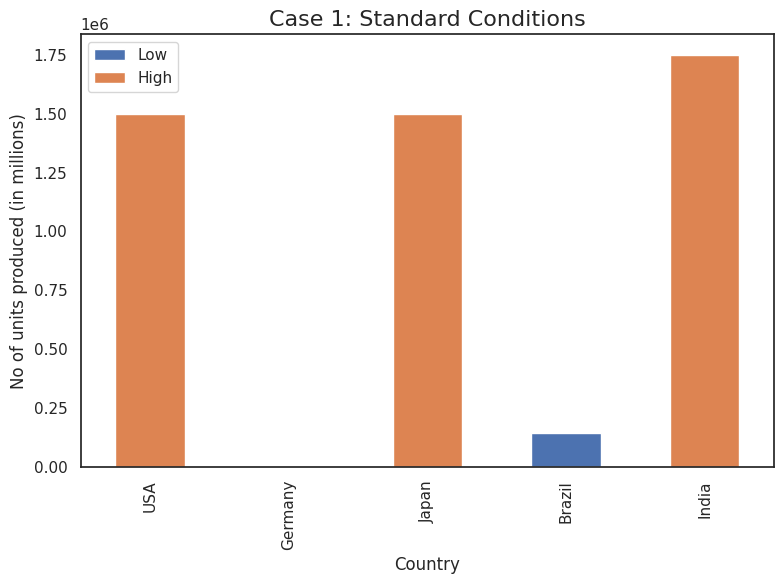

In [124]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(8, 6))

df_plot1.set_index("Location").plot(
    kind="bar",
    stacked=True,
    ax=ax
)

ax.set_title("Case 1: Standard Conditions", fontsize=16)
ax.set_xlabel("Country")
ax.set_ylabel("No of units produced (in millions)")

plt.tight_layout()

plt.show()


## Case 2: Freight Costs increase by 3x due to COVID pandemic

In [125]:
dict_plot2 = {'Location':['USA','Germany','Japan','Brazil','India'], 'Low':[500000,0,500000,145000,0],'High':[1500000,0,1200000,0,1050000]}
df_plot2 = pd.DataFrame(dict_plot2)
df_plot2

,Location,Low,High
0,USA,500000,1500000
1,Germany,0,0
2,Japan,500000,1200000
3,Brazil,145000,0
4,India,0,1050000


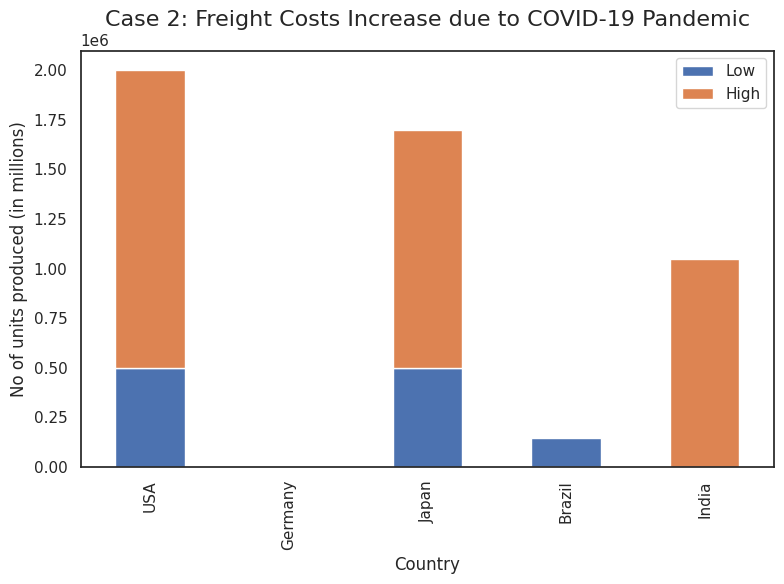

In [126]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(8, 6))

df_plot2.set_index("Location").plot(
    kind="bar",
    stacked=True,
    ax=ax
)

ax.set_title(
    "Case 2: Freight Costs Increase due to COVID-19 Pandemic",
    fontsize=16
)
ax.set_xlabel("Country")
ax.set_ylabel("No of units produced (in millions)")

plt.tight_layout()
plt.show()

In [127]:
dict_case2 = {'Location':['USA','Germany','Japan','Brazil','India'],
             'USA':[2000000,0,0,0,800000],
             'Germany':[0,0,0,0,90000],
            'Japan':[0,0,1700000,0,0],
            'Brazil':[0,0,0,145000,0],
            'India':[0,0,0,0,160000]}
df_case2 = pd.DataFrame(dict_case2)
df_case2

,Location,USA,Germany,Japan,Brazil,India
0,USA,2000000,0,0,0,0
1,Germany,0,0,0,0,0
2,Japan,0,0,1700000,0,0
3,Brazil,0,0,0,145000,0
4,India,800000,90000,0,0,160000


## Case 3: Demand increases 5x in Germany, Brazil and India

In [128]:
dict_plot3 = {'Location':['USA','Germany','Japan','Brazil','India'], 'Low':[0,0,0,0,0],'High':[1500000,0,1500000,725000,2750000]}
df_plot3 = pd.DataFrame(dict_plot3)
df_plot3

,Location,Low,High
0,USA,0,1500000
1,Germany,0,0
2,Japan,0,1500000
3,Brazil,0,725000
4,India,0,2750000


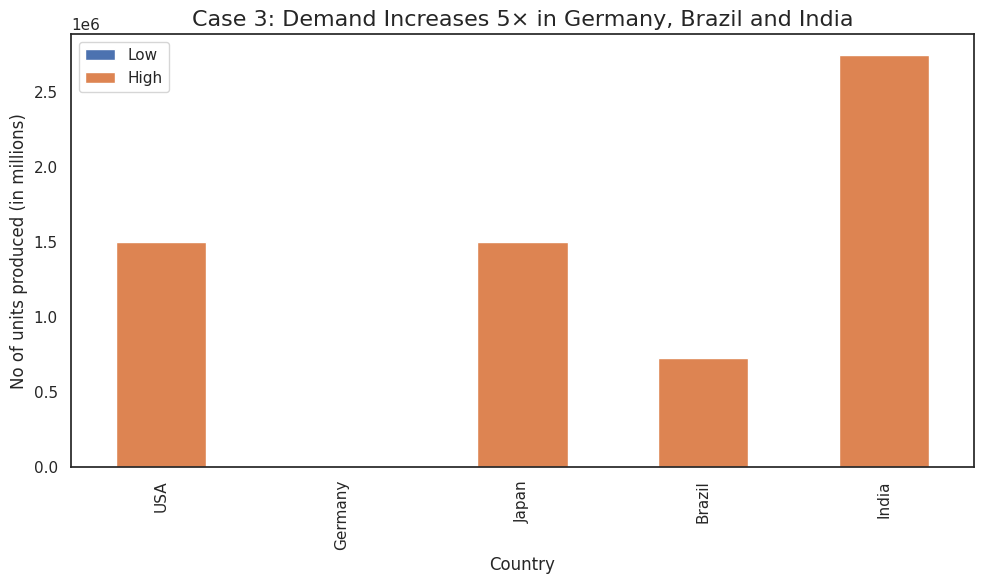

In [129]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(10, 6))

df_plot3.set_index("Location").plot(
    kind="bar",
    stacked=True,
    ax=ax
)

ax.set_title(
    "Case 3: Demand Increases 5× in Germany, Brazil and India",
    fontsize=16
)
ax.set_xlabel("Country")
ax.set_ylabel("No of units produced (in millions)")

plt.tight_layout()
plt.show()

In [130]:
dict_case3 = {'Location':['USA','Germany','Japan','Brazil','India'],
             'USA':[1300000,0,0,0,1500000],
             'Germany':[0,0,0,0,450000],
            'Japan':[200000,0,1500000,0,0],
            'Brazil':[0,0,0,725000,0],
            'India':[0,0,0,0,800000]}
df_case3 = pd.DataFrame(dict_case3)
df_case3

,Location,USA,Germany,Japan,Brazil,India
0,USA,1300000,0,200000,0,0
1,Germany,0,0,0,0,0
2,Japan,0,0,1500000,0,0
3,Brazil,0,0,0,725000,0
4,India,1500000,450000,0,0,800000


## Case 4: Variable Costs Increase 2× Across All Countries and Delivery Times Reduce by 2/3rd. High Capacity Plant in India Reduces Capacity by 50%

* Variable costs increase 2x across all countries and delivery times reduce by 2/3rd.
* High capacity plant in India reduces capacity by 50%

In [131]:
dict_plot4 = {'Location':['USA','Germany','Japan','Brazil','India'], 'Low':[0,0,0,145000,500000],'High':[1250000,0,1500000,0,1500000]}
df_plot4 = pd.DataFrame(dict_plot4)
df_plot4

,Location,Low,High
0,USA,0,1250000
1,Germany,0,0
2,Japan,0,1500000
3,Brazil,145000,0
4,India,500000,1500000


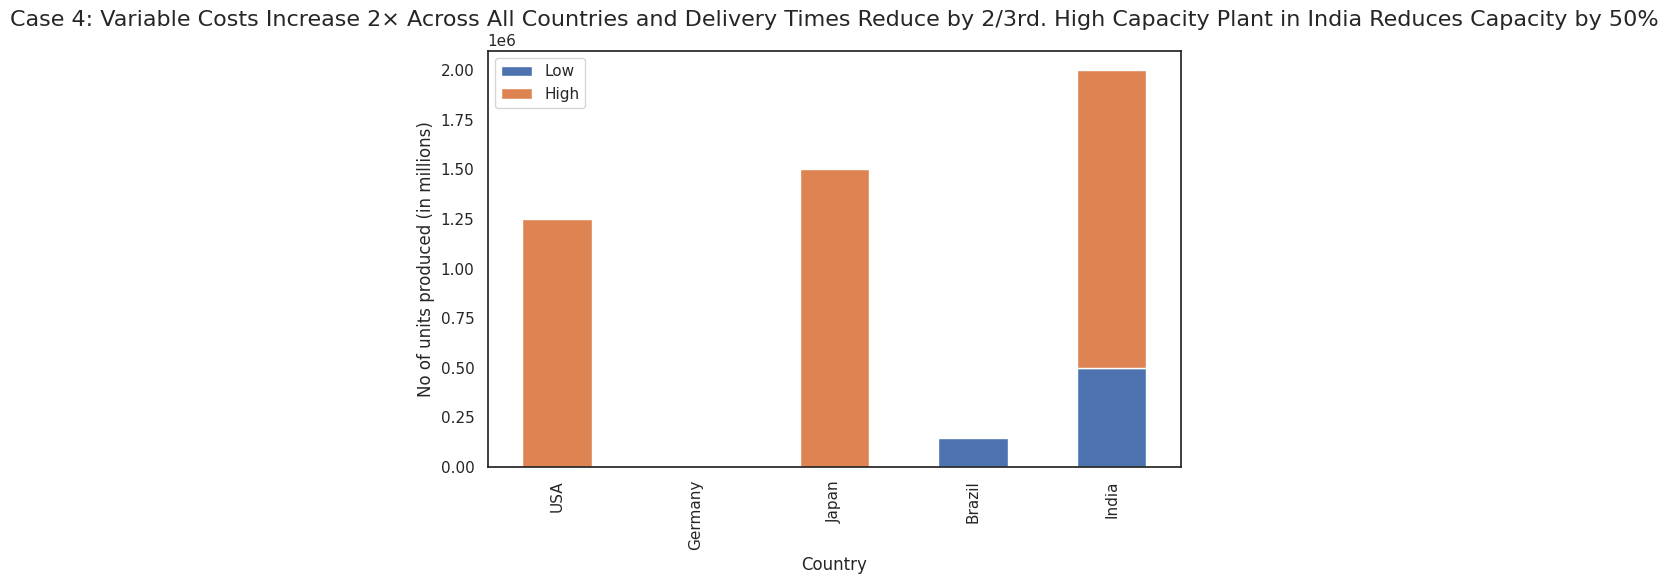

In [132]:
sns.set(style="white")

fig, ax = plt.subplots(figsize=(8, 6))

df_plot4.set_index("Location").plot(
    kind="bar",
    stacked=True,
    ax=ax
)

ax.set_title(
    "Case 4: Variable Costs Increase 2× Across All Countries and Delivery Times Reduce by 2/3rd. High Capacity Plant in India Reduces Capacity by 50%",
    fontsize=16)
ax.set_xlabel("Country")
ax.set_ylabel("No of units produced (in millions)")

plt.tight_layout()
plt.show()

In [133]:
dict_case4 = {'Location':['USA','Germany','Japan','Brazil','India'],
             'USA':[1050000,0,0,0,1750000],
             'Germany':[0,0,0,0,900000],
            'Japan':[200000,0,1500000,0,0],
            'Brazil':[0,0,0,145000,0],
            'India':[0,0,0,0,160000]}
df_case4 = pd.DataFrame(dict_case4)
df_case4

,Location,USA,Germany,Japan,Brazil,India
0,USA,1050000,0,200000,0,0
1,Germany,0,0,0,0,0
2,Japan,0,0,1500000,0,0
3,Brazil,0,0,0,145000,0
4,India,1750000,900000,0,0,160000


## Case 5: CO2 emission limits set at 500,000 kgs/ton and storage costs increase 2x. High capacity plants at all countries set at 1000k units

* $CO_2$ emission limits set at 50,000 kgs/ton/liter and storage costs increase 2x. High capacity plants at all countries set at 1000k units

In [134]:
dict_plot5 = {'Location':['USA','Germany','Japan','Brazil','India'], 'Low':[500000,0,500000,395000,500000],'High':[1000000,0,1000000,0,1000000]}
df_plot5 = pd.DataFrame(dict_plot5)
df_plot5

,Location,Low,High
0,USA,500000,1000000
1,Germany,0,0
2,Japan,500000,1000000
3,Brazil,395000,0
4,India,500000,1000000


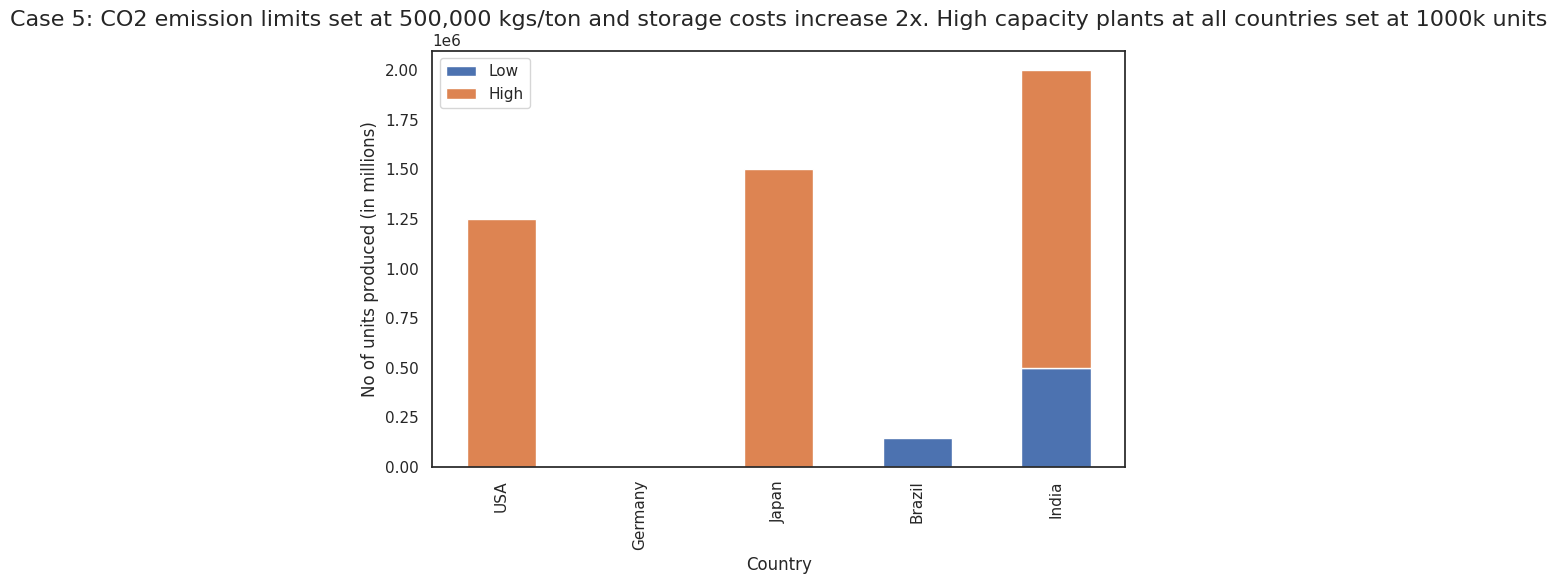

In [135]:
sns.set(style="white")

fig, ax = plt.subplots(figsize=(8, 6))

df_plot4.set_index("Location").plot(
    kind="bar",
    stacked=True,
    ax=ax
)

ax.set_title(
    "Case 5: CO2 emission limits set at 500,000 kgs/ton and storage costs increase 2x. High capacity plants at all countries set at 1000k units",
    fontsize=16)
ax.set_xlabel("Country")
ax.set_ylabel("No of units produced (in millions)")

plt.tight_layout()
plt.show()

In [136]:

dict_case5 = {'Location':['USA','Germany','Japan','Brazil','India'],
             'USA':[1300000,0,0,250000,1250000],
             'Germany':[0,0,0,0,900000],
            'Japan':[200000,0,1500000,0,0],
            'Brazil':[0,0,0,145000,0],
            'India':[0,0,0,0,160000]}
df_case5 = pd.DataFrame(dict_case5)
df_case5

,Location,USA,Germany,Japan,Brazil,India
0,USA,1300000,0,200000,0,0
1,Germany,0,0,0,0,0
2,Japan,0,0,1500000,0,0
3,Brazil,250000,0,0,145000,0
4,India,1250000,900000,0,0,160000
